get new model...


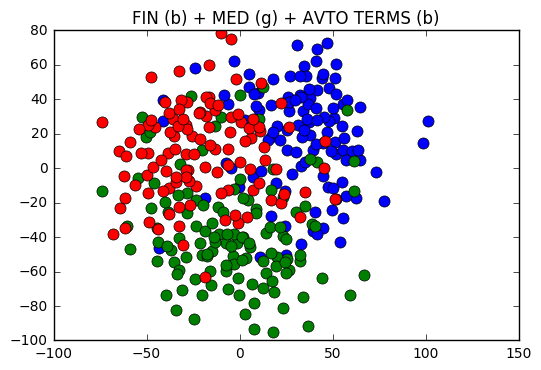

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


NameError: name 'new_avto_vecs' is not defined

In [1]:
# coding=utf-8
import os
import re
import codecs
import gensim
import logging
import numpy as np
import matplotlib.pyplot as plt

from scripts.testWord2Vec import model
from operator import itemgetter
from collections import defaultdict
from sklearn.manifold import TSNE

def getWordVecs(words):
    vecs = []
    for word in words:
        word = word.replace('\n', '')
        try:
            if ruwiki_model.model_word_from_word.get(word) != None:
                vecs.append(ruwiki_model.model[ruwiki_model.model_word_from_word[word]].reshape((1,300)))
        except KeyError:
            continue
    vecs = np.concatenate(vecs)
    return np.array(vecs, dtype='float') #TSNE expects float type values

def getNewWordVecs(words):
    vecs = []
    for word in words:
        word = word.replace('\n', '')
        try:
            if new_model.get(word) != None:
                vecs.append(new_model[word].reshape((1,300)))
        except KeyError:
            continue
    vecs = np.concatenate(vecs)
    return np.array(vecs, dtype='float') #TSNE expects float type values
    
def load_model(file_name):
    # TODO: it's for current implementation
    dir_name = os.path.dirname(os.path.realpath('__file__'))
    name = os.path.join(*[dir_name, '..', file_name])
    the_model = model(name)
    return the_model


if __name__ == "__main__":
    # ------------ web --------------------
    #web_model_size = 353608
    #web_model_file_name = 'web.model.bin'
    
    # ------------ news ------------------
    #news_model_size = 124590
    #news_model_file_name = 'news.model.bin'

    # ---------- ruscorpora -------------
    #rus_model_size = 184973
    #rus_model_file_name = 'ruscorpora.model.bin'

    # ---------- ruwikiruscorpora -------------
    ruwiki_model_size = 392339
    ruwiki_model_file_name = 'ruwikiruscorpora.model.bin'
    ruwiki_model = load_model(ruwiki_model_file_name)
    

    dir_name = os.path.dirname(os.path.realpath('__file__'))
    pref_file_path = os.path.join(*[dir_name, 'dicts', 'prefixes.txt'])
    suff_file_path = os.path.join(*[dir_name, 'dicts', 'suffixes.txt'])
    finTerms_file_path = os.path.join(*[dir_name, 'dicts', 'finTerms.txt'])
    medTerms_file_path = os.path.join(*[dir_name, 'dicts', 'med200Terms.txt'])
    avtoTerms_file_path = os.path.join(*[dir_name, 'dicts', 'avto200Terms.txt'])
    
    new_model = ruwiki_model.get_new_morphemes_model(pref_file_path, suff_file_path)
    
    with codecs.open(finTerms_file_path, 'r', encoding='utf-8') as infile:
        fin_words = infile.readlines()
    
    with codecs.open(medTerms_file_path, 'r', encoding='utf-8') as infile:
        med_words = infile.readlines()
    
    with codecs.open(avtoTerms_file_path, 'r', encoding='utf-8') as infile:
        avto_words = infile.readlines()
        
    fin_vecs = getWordVecs(fin_words)
    for vec in fin_vecs:
        with codecs.open('fin_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')
    
    med_vecs = getWordVecs(med_words)
    for vec in med_vecs:
        with codecs.open('med_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')

    avto_vecs = getWordVecs(avto_words)
    for vec in med_vecs:
        with codecs.open('avto_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')
                
    fin_vecs = np.nan_to_num(fin_vecs)
    med_vecs = np.nan_to_num(med_vecs)
    avto_vecs = np.nan_to_num(avto_vecs)
    
    ts = TSNE(2)
    reduced_vecs = ts.fit_transform(np.concatenate((fin_vecs, med_vecs, avto_vecs)))
    #reduced_vecs = ts.fit_transform(fin_vecs)
    
    #color points by word group to see if Word2Vec can separate them
    for i in range(len(reduced_vecs)):      
        if i < len(fin_vecs):
            color = 'b'
        elif i >= len(fin_vecs) and i < (len(fin_vecs) + len(med_vecs)):
            color = 'g'
        else:
            color = 'r'
        #color = 'b'
        plt.plot(reduced_vecs[i,0], reduced_vecs[i,1], marker='o', color=color, markersize=8)
        plt.title('FIN (b) + MED (g) + AVTO TERMS (b)')
    plt.show()
    
    # NEW MODEL
    
    new_fin_vecs = getNewWordVecs(fin_words)
    for vec in fin_vecs:
        with codecs.open('new_model_fin_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')
    
    new_med_vecs = getNewWordVecs(med_words)
    for vec in med_vecs:
        with codecs.open('new_model_med_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')

    new_avto_vecs = getNewWordVecs(avto_words)
    for vec in med_vecs:
        with codecs.open('new_model_avto_vects.txt', 'a', encoding='utf-8') as outfile:
                outfile.write(str(vec).decode('utf-8'))
                outfile.write('\n')
                
    new_fin_vecs = np.nan_to_num(new_fin_vecs)
    new_med_vecs = np.nan_to_num(new_med_vecs)
    new_avto_vecs = np.nan_to_num(new_avto_vecs)
    
    ts = TSNE(2)
    new_reduced_vecs = ts.fit_transform(np.concatenate((new_fin_vecs, new_med_vecs, new_avto_vecs)))
    
    #color points by word group to see if new model can separate them
    for i in range(len(new_reduced_vecs)):      
        if i < len(new_fin_vecs):
            color = 'b'
        elif i >= len(new_fin_vecs) and i < (len(new_fin_vecs) + len(new_med_vecs)):
            color = 'g'
        else:
            color = 'r'
        #color = 'b'
        plt.plot(new_reduced_vecs[i,0], new_reduced_vecs[i,1], marker='o', color=color, markersize=8)
        plt.title(' NEW MODEL: FIN (b) + MED (g) + AVTO TERMS (b)')
    plt.show()


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


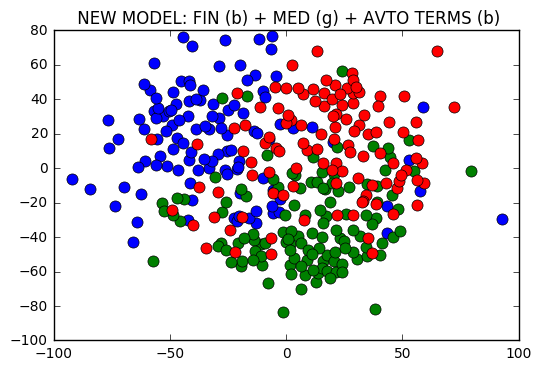

In [2]:
# NEW MODEL
    
new_fin_vecs = getNewWordVecs(fin_words)
for vec in fin_vecs:
    with codecs.open('new_model_fin_vects.txt', 'a', encoding='utf-8') as outfile:
            outfile.write(str(vec).decode('utf-8'))
            outfile.write('\n')

new_med_vecs = getNewWordVecs(med_words)
for vec in med_vecs:
    with codecs.open('new_model_med_vects.txt', 'a', encoding='utf-8') as outfile:
            outfile.write(str(vec).decode('utf-8'))
            outfile.write('\n')

new_avto_vecs = getNewWordVecs(avto_words)
for vec in med_vecs:
    with codecs.open('new_model_avto_vects.txt', 'a', encoding='utf-8') as outfile:
            outfile.write(str(vec).decode('utf-8'))
            outfile.write('\n')

new_fin_vecs = np.nan_to_num(new_fin_vecs)
new_med_vecs = np.nan_to_num(new_med_vecs)
new_avto_vecs = np.nan_to_num(new_avto_vecs)

ts = TSNE(2)
new_reduced_vecs = ts.fit_transform(np.concatenate((new_fin_vecs, new_med_vecs, new_avto_vecs)))

#color points by word group to see if new model can separate them
for i in range(len(new_reduced_vecs)):      
    if i < len(new_fin_vecs):
        color = 'b'
    elif i >= len(new_fin_vecs) and i < (len(new_fin_vecs) + len(new_med_vecs)):
        color = 'g'
    else:
        color = 'r'
    #color = 'b'
    plt.plot(new_reduced_vecs[i,0], new_reduced_vecs[i,1], marker='o', color=color, markersize=8)
    plt.title(' NEW MODEL: FIN (b) + MED (g) + AVTO TERMS (b)')
plt.show()

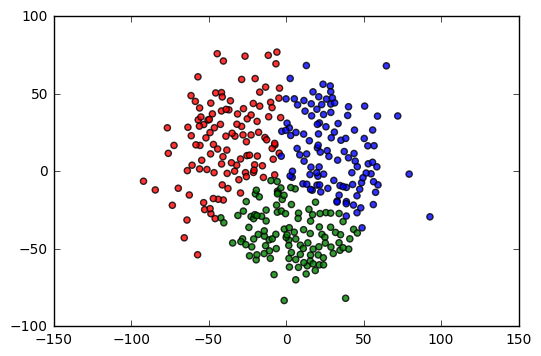

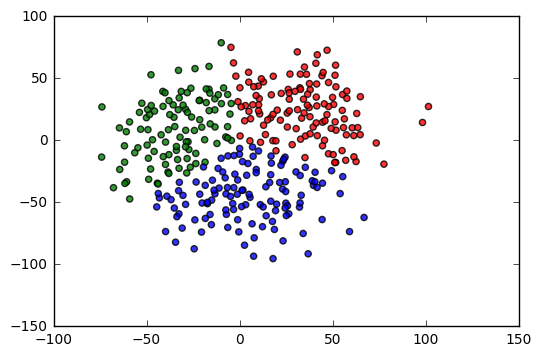

In [20]:
from sklearn import mixture
 
def fit_samples(samples):
    gmix = mixture.GaussianMixture(n_components=3, covariance_type='full')
    gmix.fit(samples)
    colors = []
    for i in gmix.predict(samples):
        if i==0:
            colors.append('r')
        elif i==1:
            colors.append('g')
        else:
            colors.append('b')
    #colors = ['r' if i==0 else 'g' if i==1 else 'b' for i in gmix.predict(samples)]
    ax = plt.gca()
    ax.scatter(samples[:,0], samples[:,1], c=colors, alpha=0.8)
    plt.show()
    
fit_samples(new_reduced_vecs)
fit_samples(reduced_vecs)

[[  3.94358284 -43.17852336]
 [-32.10237156   9.16261097]
 [ 33.19000752  23.66995734]]


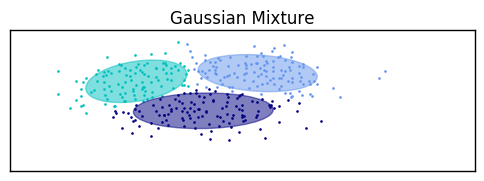

[350712.48635054147, 234836.82580183516, 267021.4883231968]
[[-37.05451222  18.12144411]
 [ 27.78735848  16.55017646]
 [  5.14705291 -36.39107159]]


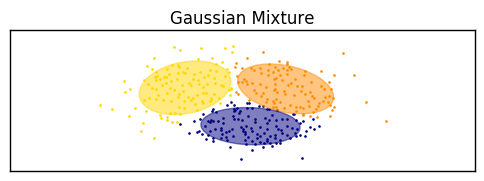

[299589.1520972709, 268202.21829094307, 177751.26258385205]


In [53]:
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange'])


def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)


# Generate random sample, two components
np.random.seed(0)
X = reduced_vecs
X1 = new_reduced_vecs
 
# Fit a Gaussian mixture with EM using five components
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X)
print gmm.means_
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
#plot_results(X, X[1], gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
plt.show()

print map(lambda x: linalg.det(x), gmm.covariances_)

gmm = mixture.GaussianMixture(n_components=3, covariance_type='full').fit(X1)
print gmm.means_
plot_results(X1, gmm.predict(X1), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
#plot_results(X1, X1[1], gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')


# Fit a Dirichlet process Gaussian mixture using five components
#dpgmm = mixture.BayesianGaussianMixture(n_components=3,
#                                        covariance_type='full').fit(X)
#plot_results(X, dpgmm.predict(X), dpgmm.means_, dpgmm.covariances_, 1,
#             'Bayesian Gaussian Mixture with a Dirichlet process prior')


plt.show()

print map(lambda x: linalg.det(x), gmm.covariances_)